In [52]:
import pandas as pd
import numpy as np
import time
import random
import gc
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from utils import ReadCSV, ProcessChunk, Timer, RandomSample

## 参数设置

In [17]:
# 是否为线下调试
debug = True
# ! mkdir stats
! ls -al

total 4096
drwxr-xr-x  13 niudong  staff      416  6  1 20:47 .
drwxr-xr-x   9 niudong  staff      288  5 31 21:00 ..
-rw-r--r--@  1 niudong  staff     6148  5 30 22:54 .DS_Store
drwxr-xr-x   5 niudong  staff      160  6  1 10:03 .ipynb_checkpoints
drwxr-xr-x   3 niudong  staff       96  6  1 11:39 __pycache__
-rw-r--r--   1 niudong  staff    57674  6  1 20:42 analysis.ipynb
-rw-r--r--@  1 niudong  staff    20751  5 29 15:53 baseline.ipynb
drwxr-xr-x   7 niudong  staff      224  6  1 10:31 real-stats
drwxr-xr-x  20 niudong  staff      640  6  1 10:03 stats
-rw-r--r--   1 niudong  staff  1670182  5 29 15:52 train_processed.csv
-rw-r--r--   1 niudong  staff     2425  6  1 11:39 utils.py
-rw-r--r--   1 niudong  staff   309182  6  1 10:04 v1.ipynb
-rw-r--r--@  1 niudong  staff    12739  6  1 20:47 大数据挑战赛-analysis.ipynb


In [18]:
# 数据集参数
if debug:
    !ls -lh ../data
    data_dir = "../data/"
    train_data_file = data_dir + "train_data.csv"
    test_data_file = data_dir + "test_data.csv"
else:
    !ls -lh /home/kesci/input/bytedance/first-round/
    data_dir = "/home/kesci/input/bytedance/first-round/"
    train_data_file = data_dir + "train.csv"
    test_data_file = data_dir + "test.csv"
# csv的header
ori_train_names = ["query_id", "query", "query_title_id", "title", "label"]
ori_test_names = ["query_id", "query", "query_title_id", "title"]

total 5296
-rw-r--r--  1 niudong  staff   155B  5 30 18:41 test_data.csv
-rw-r--r--@ 1 niudong  staff   1.7M  5 29 14:28 train_data.csv
-rw-r--r--@ 1 niudong  staff   282K  5 13 12:17 大数据挑战赛_sample.txt


## 辅助打印函数

In [19]:
def Plot(plot_param, 
         plot_func,
         xlabel,
         ylabel,
         savefile,
         figsize=(8, 4), 
         vertical=False):
    plt.figure(figsize=figsize)
    plot_func(**plot_param)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    if vertical:
        plt.xticks(rotation='vertical')
    plt.savefig(savefile)
    plt.show()

In [20]:
def PlotBar(dfx, dfy, 
            xlabel, 
            ylabel, 
            savefile, 
            figsize=(8, 4), 
            vertical=False):    
    Plot({"x":dfx, "y":dfy, "alpha":0.8}, 
         sns.barplot,
         xlabel, 
         ylabel, 
         savefile,
         figsize,
         vertical
        )

In [21]:
def PlotBox(df, 
            x, y, 
            xlabel, 
            ylabel, 
            savefile, 
            figsize=(12, 6),
            vertical=False):
    Plot({"x":x, "y":y, "data":df}, 
         sns.boxplot,
         xlabel, 
         ylabel, 
         savefile,
         figsize,
         vertical
        )

In [22]:
def PlotPoint(x, y, 
              xlabel, 
              ylabel, 
              savefile, 
              figsize=(12, 8), 
              vertical=False):
    Plot({"x":x, "y":y, "alpha":0.8}, 
         sns.pointplot,
         xlabel, 
         ylabel, 
         savefile,
         figsize,
         vertical
        )

## 分析函数

In [23]:
# 看label的分布
def AnalysisLabel(df):
    print("--->Label Ananlysis")
    count_label = df["label"].value_counts()
    PlotBar(count_label.index, 
            count_label.values, 
            xlabel="Clicked",
            ylabel="Number of occurrences",
            savefile= stat_save_dir+"label_dis.png"
           )
    print(count_label / count_label.sum())
    del count_label
    gc.collect()

In [67]:
# 看feature的单词数目分布
def AnalysisFeatureWordNum(df, name="query", label_rel=True):
    print("--->Word num in feature " + name)
    # print(df[name][:10])
    tmp = df[name].apply(
        lambda x: len(str(x).split(" "))
    )
    # print(tmp[:10])
    tmp_count = tmp.value_counts()
    PlotBar(tmp_count.index,  # feature中单词的数目
            tmp_count.values,  # 固定数目feature出现的次数
            xlabel="Number of words in " + name,
            ylabel="Number of occurrences",
            savefile=stat_save_dir+"word_num_in_"+name+".png",
            vertical=True
           )
    if label_rel:
        num_df = pd.DataFrame({
            "feature_word_num_log1p": np.log1p(tmp),
            "label": df["label"]
        })
        PlotBox(num_df, x="label", y="feature_word_num_log1p", 
                xlabel="clicked", ylabel=name+" word num log1p",
                savefile=stat_save_dir+"word_num_box_in_"+name+".png"
               )
        del num_df
    
    del tmp
    gc.collect()

In [70]:
# 看组合feature的单词数目分布
def AnalysisConcatWordNum(df, label_rel=True):
    print("--->Word num in concat feature")
    tmp = df.apply(
        lambda x : len(str(x["query"]).split(" ")) + len(str(x["title"]).split(" ")),
        axis = 1
    )
    # print(tmp[:10])
    feature_words_count = tmp.value_counts()
    PlotBar(feature_words_count.index, 
            feature_words_count.values, 
            xlabel="Number of words in concat feature",
            ylabel="Number of occurrences",
            savefile=stat_save_dir+"word_num_in_concat.png",
            vertical=True
           )
    
    if label_rel:
        tmp_df = pd.DataFrame({
            "concat_word_num_log1p": np.log1p(tmp),
            "label": df["label"]
        })
        PlotBox(tmp_df, x="label", y="concat_word_num_log1p", 
                xlabel="clicked", ylabel="concat word num log1p",
                savefile=stat_save_dir+"word_num_box_in_concat.png"
               )
        
    # 统计字符级别的长度
#     all_feature_df["concat_chars_count"] = all_feature_df["features"].apply(
#         lambda x: len(str(x))
#     )
#     feature_chars_count = all_feature_df["concat_chars_count"].value_counts()
#     PlotBar(feature_chars_count.index, 
#             feature_chars_count.values, 
#             xlabel="Number of characters in concat",
#             ylabel="Number of occurrences",
#             vertical=True
#            )
    
    del tmp, tmp_df
    gc.collect()

In [47]:
# # 看组合feature的单词数目分布
# def AnalysisConcatWordNum(word_num, label):
#     print("--->Word num in concat feature")
#     # print(tmp[:10])
#     count = word_num.value_counts()
#     PlotBar(count.index, 
#             count.values, 
#             xlabel="Number of words in concat feature",
#             ylabel="Number of occurrences",
#             savefile=stat_save_dir+"word_num_in_concat.png",
#             vertical=True
#            )
    
#     tmp_df = pd.DataFrame({
#         "concat_word_num_log1p": np.log1p(word_num),
#         "label": label
#     })
#     PlotBox(tmp_df, x="label", y="concat_word_num_log1p", 
#             xlabel="clicked", ylabel="concat word num log1p",
#             savefile=stat_save_dir+"word_num_box_in_concat.png"
#            )
        
#     # 统计字符级别的长度
# #     all_feature_df["concat_chars_count"] = all_feature_df["features"].apply(
# #         lambda x: len(str(x))
# #     )
# #     feature_chars_count = all_feature_df["concat_chars_count"].value_counts()
# #     PlotBar(feature_chars_count.index, 
# #             feature_chars_count.values, 
# #             xlabel="Number of characters in concat",
# #             ylabel="Number of occurrences",
# #             vertical=True
# #            )
    
#     del tmp_df
#     gc.collect()

# def genConcatLen(df):
#     tmp = df.apply(
#         lambda x : len(str(x["query"]).split(" ")) + len(str(x["title"]).split(" ")),
#         axis = 1
#     )
#     return tmp, df["label"]

In [75]:
# 分析两个特征UniGram关系
def AnalysisGrams(df):
    print("--->Common gram stat")
    df["common_unigram_count"] = df.apply(
        lambda x: len(set(str(x["query"]).split()).intersection(
            set(str(x["title"]).split())
        )),
        axis=1
    )
    df["common_unigram_ratio"] = df.apply(
        lambda x: float(x["common_unigram_count"]) / max(
                len(
                    set(str(x["query"]).split()).union(
                        set(str(x["title"]).split())
                    )
                ), 
                1
            )
        ,
        axis=1
    )    
    cnt_srs = df['common_unigram_count'].value_counts()
    PlotBar(cnt_srs.index, 
            cnt_srs.values, 
            xlabel='Common unigram count',
            ylabel="Number of occurrences",
            savefile=stat_save_dir+"common_unigram_count.png",
            vertical=True
           )
    PlotBox(df, x="label", y="common_unigram_count", 
            xlabel="clicked", ylabel="common unigram count",
            savefile=stat_save_dir+"common_unigram_count_box.png"
           )
    PlotBox(df, x="label", y="common_unigram_ratio", 
            xlabel="clicked", ylabel="common unigram radio",
           savefile=stat_save_dir+"common_unigram_radio_box.png")
    # print(df[:3])
    df.drop(['common_unigram_count', 'common_unigram_ratio'], axis=1)
    gc.collect()
    

In [62]:
# 分析两个feature的交集关系
def AnalysisIntersect(df, test_df):
    all_df = pd.concat([df[["query", "title"]], 
                        test_df[["query", "title"]]],
                      axis=0).reset_index(drop="index")
    print("Shape concated train and test:", all_df.shape)
    
    with Timer("Create dict"):
        from collections import defaultdict
        q_dict = defaultdict(set)
        for _ in range(all_df.shape[0]):
            # 存储的是一个query对应哪几个title和
            # 一个title对应哪几个query
            q_dict[all_df["query"][_]].add(all_df["title"][_])
            q_dict[all_df["title"][_]].add(all_df["query"][_])
    
    # 这里的频率是一个query会对应几个title
    def q1Freq(row):
        return len(q_dict[row['query']])
    def q2Freq(row):
        return len(q_dict[row['title']]) 
    def q1q2FreqIntersect(row):
        return len(
            set(q_dict[row['query']]
        ).intersection(
                set(q_dict[row['title']])
        ))
    
    freq_df = pd.DataFrame(
          {
            "query_freq":df.apply(
                q1Freq, axis=1, raw=True
            ),
            "title_freq":df.apply(
                q2Freq, axis=1, raw=True
            ),
            "query_title_intersect":df.apply(
                q1q2FreqIntersect, axis=1, raw=True
            ),
            "label": df["label"]
        }
    )
    
    # 看交集出现的次数
    cnt_srs = freq_df['query_title_intersect'].value_counts()
    PlotBar(cnt_srs.index, 
            np.log1p(cnt_srs.values), 
            xlabel='Query-Title neighbor intersection count',
            ylabel="Log of Number of Occurrences",
            vertical=True,
            savefile=stat_save_dir+"query_title_intersect_count.png"
           )
    
    # 看交集出现次数跟label的关系
    grouped_df = freq_df.groupby('query_title_intersect')['label'].aggregate(np.mean).reset_index()
    PlotPoint(
        grouped_df["query_title_intersect"].values,
        grouped_df["label"].values,
        ylabel="Mean clicked",
        xlabel="Q1-Q2 neighbor intersection count",
        vertical=True,
        savefile=stat_save_dir+"query_title_intersect_impact_label.png"
    )
    
    # 看每个query的title次数
    cnt_srs = freq_df['query_freq'].value_counts()
    PlotBar(cnt_srs.index, 
            cnt_srs.values, 
            xlabel='Query Frequency',
            ylabel="Number of Occurrences",
            vertical=True,
            savefile=stat_save_dir+"query_frequency_count.png"
           )
    
    # 看每个title的query次数
    cnt_srs = freq_df['title_freq'].value_counts()
    PlotBar(cnt_srs.index, 
            cnt_srs.values, 
            xlabel='Title Frequency',
            ylabel="Number of Occurrences",
            vertical=True,
            savefile=stat_save_dir+"title_frequency_count.png"
           )
    
    # 看query出现频率对于label的影响
    grouped_df = freq_df.groupby('query_freq')['label'].aggregate(np.mean).reset_index()
    PlotPoint(
        grouped_df["query_freq"].values,
        grouped_df["label"].values,
        ylabel="Mean clicked",
        xlabel="Q1 Frequency",
        vertical=True,
        savefile=stat_save_dir+"query_impact_label.png"
    )
    
    # 数据透视表: https://blog.csdn.net/qq_36495431/article/details/81123240
    # 看query频率、title频率与label的关系
    pvt_df = freq_df.pivot_table(index="query_freq", 
                                 columns="title_freq", 
                                 values="label")
    plt.figure(figsize=(12,12))
    sns.heatmap(pvt_df)
    plt.title("Mean clicked value distribution across query and title frequency")
    plt.savefig(stat_save_dir+"query_title_impact_label.png")
    plt.show()
    
    # 三者关系
    cols_to_use = ['query_title_intersect', 'query_freq', 'title_freq']
    tmp_df = freq_df[cols_to_use]
    corrmat = tmp_df.corr(method='spearman')
    f, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(corrmat, vmax=1., square=True)
    plt.title("Leaky variables correlation map", fontsize=15)
    plt.savefig(stat_save_dir+"correlation.png")
    plt.show()
    
    del all_df, q_dict, freq_df, grouped_df, pvt_df, tmp_df
    gc.collect()

## 分析

In [27]:
stat_save_dir = "./stats/"

Random sample...
Finished sample.
--->Common gram stat


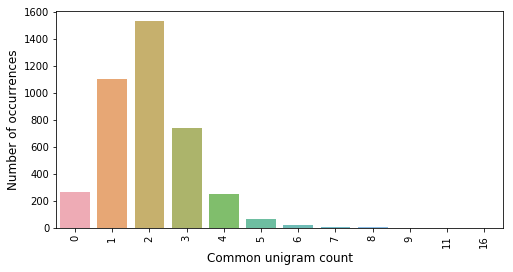

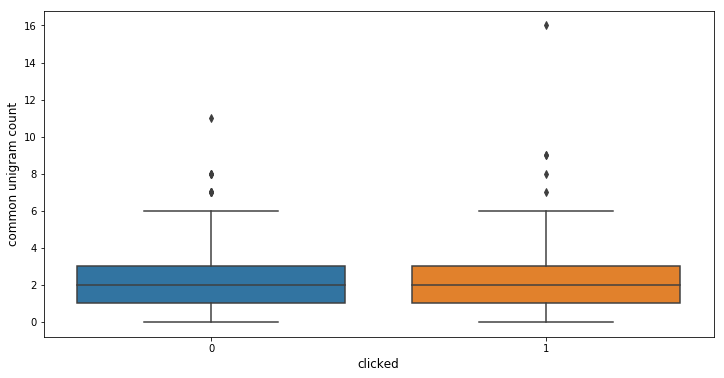

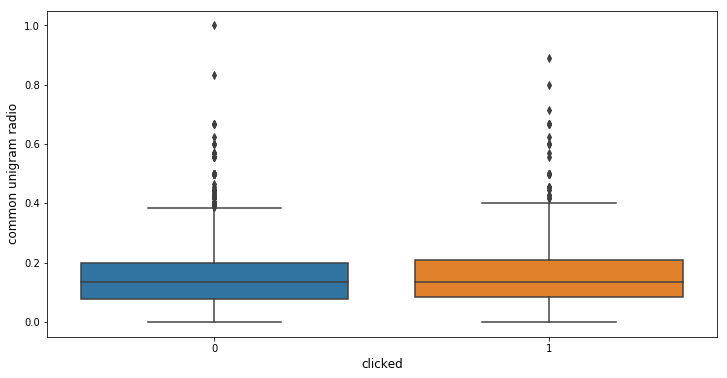

In [76]:
# 原始数据集上的分析
def AnalysisDataset(trainfile, testfile,
                     train_names=ori_train_names, 
                     test_names=ori_test_names,
                     chunk_size=5000000):
#     chunks = []
#     ap = lambda x: chunks.append(x)
#     ProcessChunk(trainfile, ap, train_names, chunk_size)
#     df = pd.concat(chunks, ignore_index=True)
    test_df = ReadCSV(testfile, names=test_names, iterator=False)
    df = RandomSample(trainfile, 0.2, names=ori_train_names, chunk_size=chunk_size)
    
#     # 可以直接跑出来
    # AnalysisLabel(df)
#     AnalysisFeatureWordNum(df, name="query")
#     AnalysisFeatureWordNum(df, name="title")
    
    # concatLen, label = [], []
    # def ap(x):
    #     tmp = genConcatLen(x)
    #     concatLen.append0(tmp[0])
    #     label.append(tmp[1])
    # ProcessChunk(trainfile, ap, train_names, chunk_size)
    # concatLen = pd.concat(concatLen)
    # label = pd.concat(label)
    # AnalysisConcatWordNum(concatLen, label)
    
#     AnalysisConcatWordNum(df)
    AnalysisGrams(df)
    
    # 混合关联
    # AnalysisIntersect(df, test_df)

if debug:
    chunk_size = 5000
else:
    chunk_size = 10000000
    
AnalysisDataset(train_data_file, test_data_file, chunk_size=chunk_size)